# Mall Customer Segmentation

**Ce notebook présente un projet de clustering appliqué à un jeu de données de clients de centre commercial disponible sur la plateforme Kaggle (https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data?select=Mall_Customers.csv).**

In [ ]:
!pip install --upgrade gspread gspread_dataframe

## 1. Chargement des données depuis Google Sheets

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

from gspread_dataframe import get_as_dataframe, set_with_dataframe
import pandas as pd

spreadsheet_url = "https://docs.google.com/spreadsheets/d/1oe5KB4exYfXGe48DOwJvKDL20aJGw8QNoJ6QZxnKW-Y/edit?usp=sharing"
sh = gc.open_by_url(spreadsheet_url)

worksheet = sh.worksheet("Mall Customers")

df = get_as_dataframe(worksheet)

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,Male,19.0,15.0,39.0
1,2.0,Male,21.0,15.0,81.0
2,3.0,Female,20.0,16.0,6.0
3,4.0,Female,23.0,16.0,77.0
4,5.0,Female,31.0,17.0,40.0


* On peut commencer par nettoyer de manière basique les colonnes et dtype des données.

In [ ]:
df.rename(columns={"CustomerID": "id",
                   "Annual Income (k$)": "annual_income",
                   "Gender": "gender",
                   "Age":"age",
                   "Spending Score (1-100)": "spending_score"}, inplace=True)

df['id'] = df['id'].astype('int64')

df['age'] = df['age'].astype('int64')

df.head()

,id,gender,age,annual_income,spending_score
0,1,Male,19,15.0,39.0
1,2,Male,21,15.0,81.0
2,3,Female,20,16.0,6.0
3,4,Female,23,16.0,77.0
4,5,Female,31,17.0,40.0


* Voici le dictionnaire des données pour expliciter ce que chaque colonne représente:

In [ ]:
data_dictionary = {"id" : "ID du client.",
                   "gender": "Genre du client.",
                   "age": "Age du client.",
                   "annual_income": "Revenu annuel du client en k$.",
                   "spending_score": "Score entre 1 et 100 attribué au client par le centre commercial basé sur le comportement client et la nature des dépenses."}

* On peut vérifier si toutes les valeurs de score sont des entiers ou bien des réels.

In [ ]:
print("Les valeurs dans la colonne spending_score peuvent être converties en int: ", df.spending_score.apply(lambda x : int(x) == x).sum() == len(df))

Les valeurs dans la colonne spending_score peuvent être converties en int:  True


In [ ]:
df['spending_score'] = df['spending_score'].astype('int64')

df.head()

,id,gender,age,annual_income,spending_score
0,1,Male,19,15.0,39
1,2,Male,21,15.0,81
2,3,Female,20,16.0,6
3,4,Female,23,16.0,77
4,5,Female,31,17.0,40


## 2. Exploration des données

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              200 non-null    int64  
 1   gender          200 non-null    object 
 2   age             200 non-null    int64  
 3   annual_income   200 non-null    float64
 4   spending_score  200 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 9.4+ KB


In [ ]:
df.describe(include="all")

,id,gender,age,annual_income,spending_score
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


### Validation / Nettoyage

* Une vérification et un nettoyage préalables ont été réalisés sur Google Sheets mais il est toujours pertinent de s'assurer de la qualité des données.

In [ ]:
df.isna().sum()

,0
id,0
gender,0
age,0
annual_income,0
spending_score,0


* Pas de valeurs manquantes

In [ ]:
df.duplicated().sum()

0

* Pas de doublons.

### Calcul et sauvegarde de statistiques dans le fichier Google Sheets

In [ ]:
import pandas as pd
from gspread_dataframe import set_with_dataframe

def analyze_data(df):
    stats = {}
    for column in df.select_dtypes(include=['number']).columns:
        stats[column] = {
            'Mean': df[column].mean(),
            'Median': df[column].median(),
            'Standard Deviation': df[column].std(),
            'Variance': df[column].var(),
            'Minimum': df[column].min(),
            'Maximum': df[column].max(),
            'Interquartile Range': df[column].quantile(0.75) - df[column].quantile(0.25),
            '25th Percentile': df[column].quantile(0.25),
            '75th Percentile': df[column].quantile(0.75),
        }

    stats_df = pd.DataFrame(stats).T
    return stats_df

def add_statistics_to_google_sheets(sh, df):
    stats_df = analyze_data(df)

    worksheet_title = "Statistics"
    try:
        sh.del_worksheet(sh.worksheet(worksheet_title))
    except gspread.exceptions.WorksheetNotFound:
        pass

    worksheet = sh.add_worksheet(title=worksheet_title, rows=100, cols=20)
    set_with_dataframe(worksheet, stats_df)

if __name__ == "__main__":

    add_statistics_to_google_sheets(sh, df)


### EDA (Exploratory Data Analysis) Dashboard

* L'image suivante représente un [dashboard](https://public.tableau.com/app/profile/nicolas.angleraud/viz/EDAMallCustomerSegmentation/EDADashboard) pour l'EDA réalisé sur Tableau Public.

Mounted at /content/drive


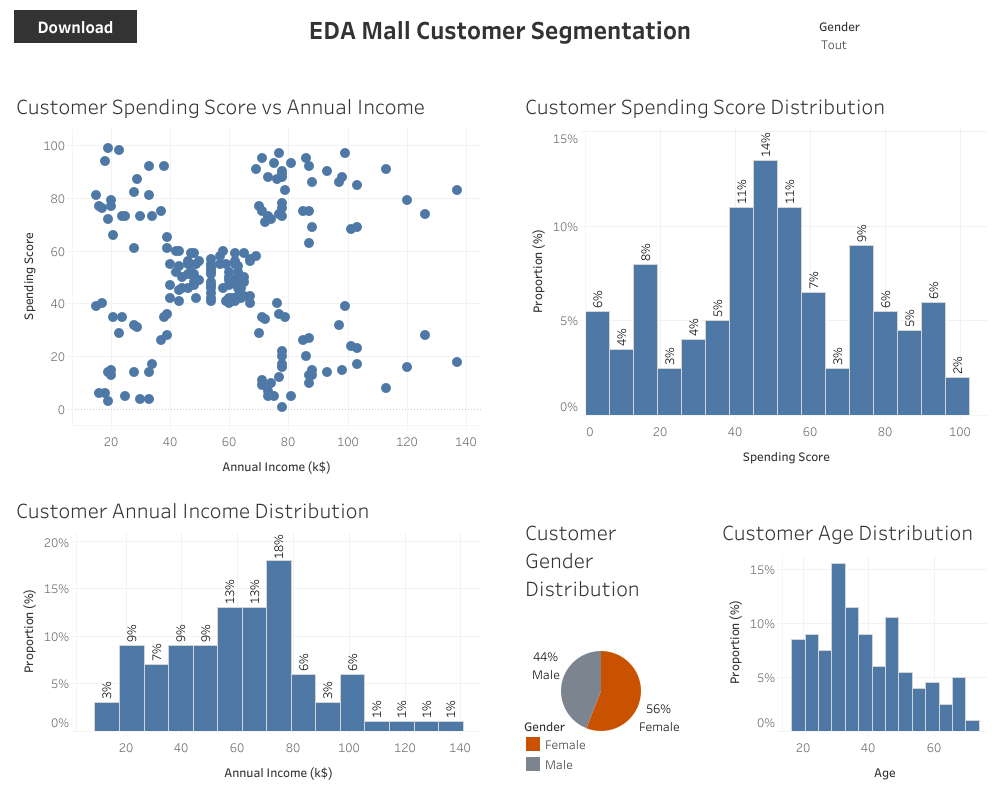

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from IPython.display import Image, display

image_path = '/content/drive/MyDrive/EDA Dashboard.png'
display(Image(filename=image_path))

## 3. K-means clustering

### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

### Préparation des données

In [ ]:
le = LabelEncoder()
df['gender_encoded'] = le.fit_transform(df['gender'])

features = ['annual_income', 'spending_score']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Modèles pour différents K

In [ ]:
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))



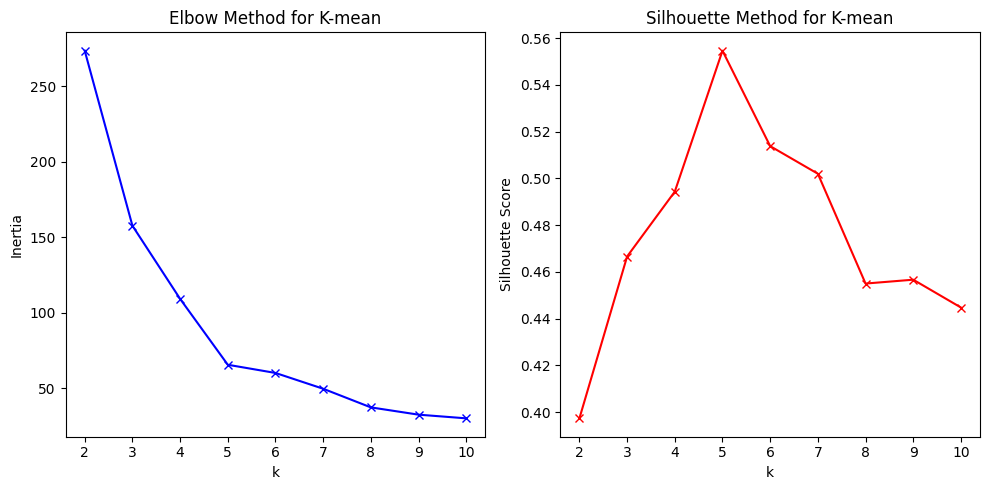

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-mean')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for K-mean')
plt.tight_layout()
plt.show()

* On peut voir que k=5 semble être la meilleure valeur car on y trouve le coude sur le graphe de l'inertie et le score de silhouette le plus élevé.

### Modèle optimal

In [ ]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

### Visualisation des clusters

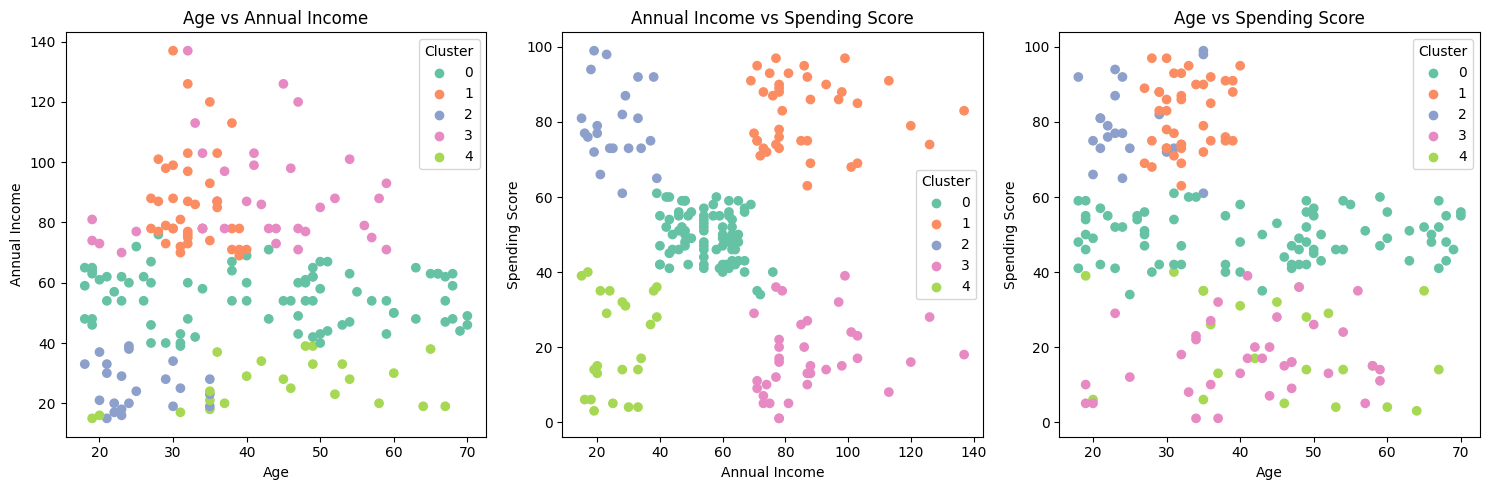

In [ ]:
palette = sns.color_palette("Set2", optimal_k)
cluster_colors = df['Cluster'].map(lambda x: palette[x])

plt.figure(figsize=(15, 5))
#plt.title("K-means clusters (k=5)")

plt.subplot(1, 3, 1)
scatter = plt.scatter(df['age'], df['annual_income'], c=cluster_colors)
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.title('Age vs Annual Income')

for cluster_id in range(optimal_k):
    plt.scatter([], [], color=palette[cluster_id], label=f'{cluster_id}')
plt.legend(title="Cluster")

plt.subplot(1, 3, 2)
scatter = plt.scatter(df['annual_income'], df['spending_score'], c=cluster_colors)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Annual Income vs Spending Score')

for cluster_id in range(optimal_k):
    plt.scatter([], [], color=palette[cluster_id], label=f'{cluster_id}')
plt.legend(title="Cluster")

plt.subplot(1, 3, 3)
scatter = plt.scatter(df['age'], df['spending_score'], c=cluster_colors)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Age vs Spending Score')

for cluster_id in range(optimal_k):
    plt.scatter([], [], color=palette[cluster_id], label=f'{cluster_id}')
plt.legend(title="Cluster")


plt.tight_layout()
plt.show()


### Table des clusters

In [ ]:
cluster_analysis = df.groupby('Cluster').agg({
    'age': ['mean', 'min', 'max'],
    'annual_income': ['mean', 'min', 'max'],
    'spending_score': ['mean', 'min', 'max']
}).round().astype(int)

cluster_analysis['nb_clients'] = df.groupby('Cluster').size()

print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
         age         annual_income          spending_score        
        mean min max          mean min  max           mean min max
Cluster                                                           
0         43  18  70            55  39   76             50  34  61
1         33  27  40            87  69  137             82  63  97
2         25  18  35            26  15   39             79  61  99
3         41  19  59            88  70  137             17   1  39
4         45  19  67            26  15   39             21   3  40


## 4. Gaussian Mixture Model (GMM)

In [ ]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

### Préparation des données

In [ ]:
le = LabelEncoder()
df['gender_encoded'] = le.fit_transform(df['gender'])

features = ['annual_income', 'spending_score']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Modèles pour différents K

In [ ]:
aic_scores = []
bic_scores = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    aic_scores.append(gmm.aic(X_scaled))
    bic_scores.append(gmm.bic(X_scaled))

    silhouette_scores.append(silhouette_score(X_scaled, labels))

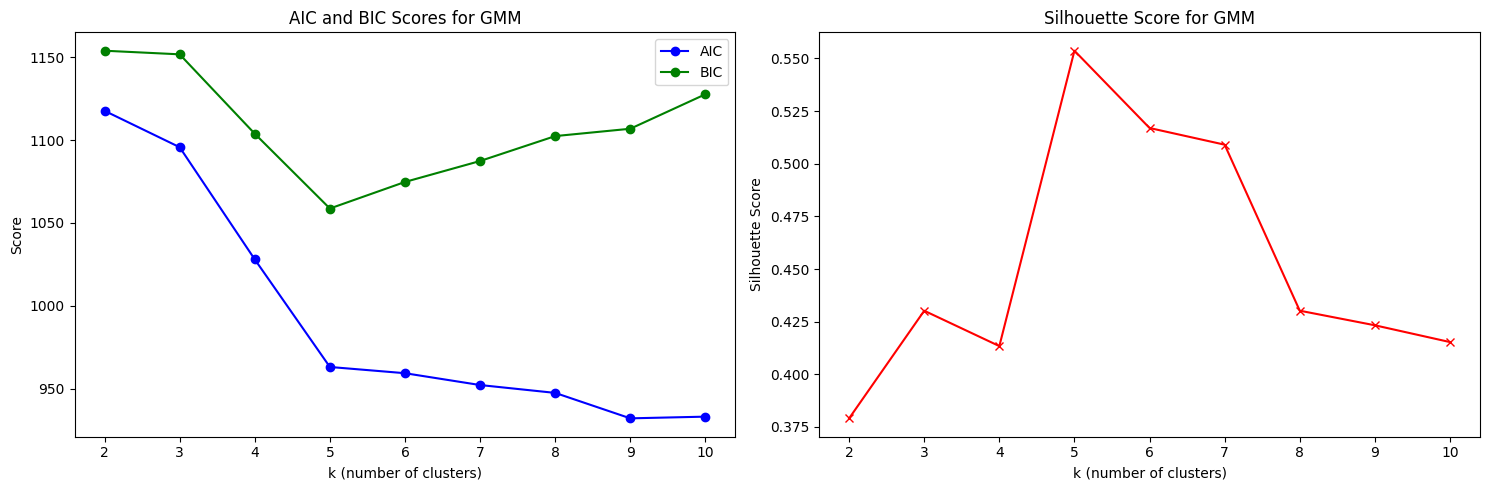

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(K, aic_scores, 'bo-', label='AIC')
plt.plot(K, bic_scores, 'go-', label='BIC')
plt.xlabel('k (number of clusters)')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for GMM')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for GMM')

plt.tight_layout()
plt.show()

* La valeur k=5 semble encore une fois optimale car on observe un coude et/ou un minimum sur les graphes de scores AIC et BIC ainsi qu'un score de silhouette maximal.

### Modèle optimal

In [ ]:
optimal_k = 5
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['Cluster'] = gmm.fit_predict(X_scaled)

### Visualisation des clusters

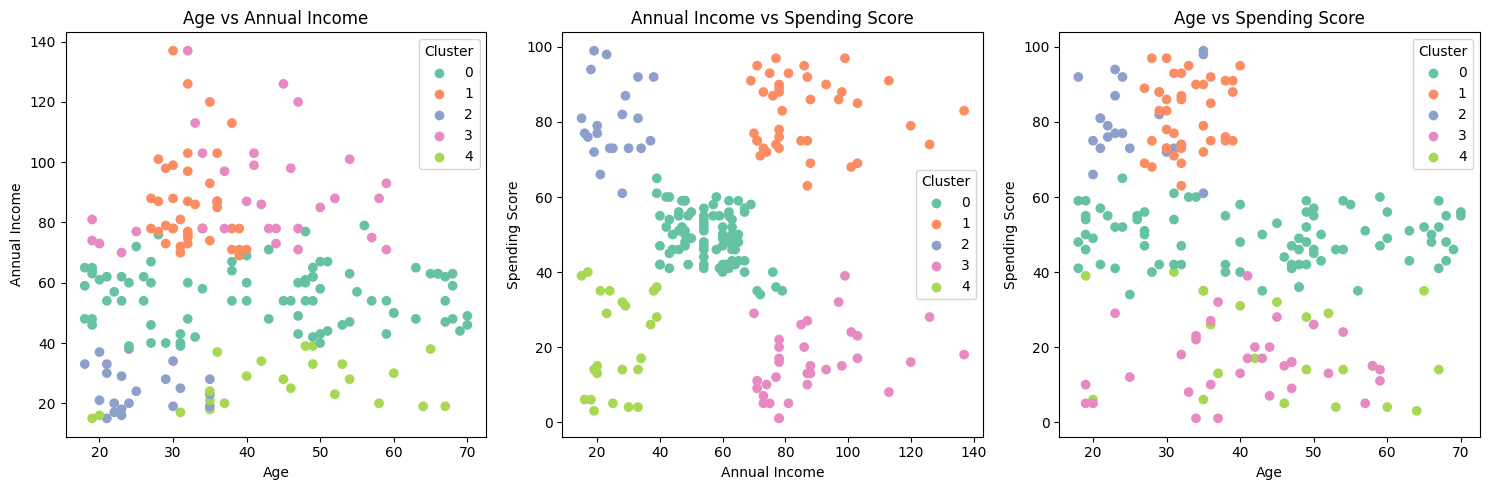

In [ ]:
palette = sns.color_palette("Set2", optimal_k)
cluster_colors = df['Cluster'].map(lambda x: palette[x])

plt.figure(figsize=(15, 5))
#plt.title("GMM clusters (k=5)")

plt.subplot(1, 3, 1)
scatter = plt.scatter(df['age'], df['annual_income'], c=cluster_colors)
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.title('Age vs Annual Income')

for cluster_id in range(optimal_k):
    plt.scatter([], [], color=palette[cluster_id], label=f'{cluster_id}')
plt.legend(title="Cluster")

plt.subplot(1, 3, 2)
scatter = plt.scatter(df['annual_income'], df['spending_score'], c=cluster_colors)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Annual Income vs Spending Score')

for cluster_id in range(optimal_k):
    plt.scatter([], [], color=palette[cluster_id], label=f'{cluster_id}')
plt.legend(title="Cluster")

plt.subplot(1, 3, 3)
scatter = plt.scatter(df['age'], df['spending_score'], c=cluster_colors)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Age vs Spending Score')

for cluster_id in range(optimal_k):
    plt.scatter([], [], color=palette[cluster_id], label=f'{cluster_id}')
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()


### Table des clusters

In [ ]:
cluster_analysis = df.groupby('Cluster').agg({
    'age': ['mean', 'min', 'max'],
    'annual_income': ['mean', 'min', 'max'],
    'spending_score': ['mean', 'min', 'max'],
}).round(2)

cluster_analysis['nb_clients'] = df.groupby('Cluster').size()

print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
           age         annual_income              spending_score        
          mean min max          mean   min    max           mean min max
Cluster                                                                 
0        42.71  18  70         55.64  39.0   79.0          49.37  34  65
1        32.69  27  40         86.54  69.0  137.0          82.13  63  97
2        25.33  18  35         25.10  15.0   38.0          80.05  61  99
3        40.45  19  59         88.82  70.0  137.0          16.00   1  39
4        45.22  19  67         26.30  15.0   39.0          20.91   3  40




*   On obtient des résultats très similaires au modèle précédent.





## 5. Interprétation

* Les deux modèles K-means et GMM produisent une analyse similaire, on peut donc penser qu'il s'agit d'une segmentation pertinente et assez solide. Dans ce cas, il s'agit en plus d'une observation qui a du sens en visualisant le nuage de points du score de dépense contre le revenu annuel avant même l'analyse des modèles. On peut donc avoir confiance dans l'intérêt de cette segmentation.


* Conclusion de la segmentation en 5 groupes :

  * **Faible revenu, faible dépense** (Cluster 4, vert) : Ce sont des clients soucieux de leur budget, avec une capacité de dépense limitée.

  * **Faible revenu, forte dépense** (Cluster 2, bleu foncé) : Des clients à faible revenu qui dépensent davantage, probablement poussés par des achats d'aspiration ou impulsifs.

  * **Revenu moyen, dépense moyenne** (Cluster 0, bleu clair) : Des acheteurs moyens avec un revenu et un niveau de dépenses modérés, représentant le client typique du centre commercial.

  * **Haut revenu, faible dépense** (Cluster 3, violet) : Des individus aisés qui dépensent prudemment, témoignant d'une attention particulière à la valeur.

  * **Haut revenu, forte dépense** (Cluster 1, orange) : Des clients aisés avec un fort pouvoir d'achat, idéaux pour des stratégies marketing de luxe.

* Idées potentielles :

    * Adapter des **stratégies marketing** ciblées pour les **clients à forte valeur**.

    * Créer des **promotions** pour encourager les dépenses chez les **clients qui dépensent moins**.

    * **Ajuster l'offre** de produits et de services pour mieux répondre aux besoins des **différents types de clients**.

## 6. Pour aller plus loin


*   Utiliser différentes combinaisons de features pour réaliser diverses segmentations afin d'obtenir potentiellement une compréhension plus profonde du comportement client.



